# Notes


Selenium needs to be installed:  
```
pip install requests beautifulsoup4
pip install selenium
```




# Selenium Approach

## Recursive Mention Crawler

When this code is run it opens chrome and ask to log in on twitter, this is required because twitter has too much limitation for guest users.

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import time
import re
from collections import defaultdict
import json
import os

# ---------- CONFIGURATION ----------
MAX_DEPTH = 5
MAX_TWEETS = 20
WAIT_TIME = 8

# ---------- UTILITY FUNCTIONS ----------
def extract_mentions(text):
    return re.findall(r"@\w+", text)

# ---------- TWITTER SCRAPER ----------
def login_to_twitter():
    chrome_options = Options()
    chrome_options.add_argument("--start-maximized")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--disable-extensions")
    chrome_options.add_argument("--disable-blink-features=AutomationControlled")

    driver = webdriver.Chrome(options=chrome_options)
    driver.get("https://twitter.com/login")
    print("\n🔐 Please log in manually in the opened browser window.")
    input("✅ Press ENTER after you have successfully logged in...\n")
    return driver

def wait_for_tweets(driver, timeout=10):
    try:
        WebDriverWait(driver, timeout).until(
            EC.presence_of_element_located((By.XPATH, "//article"))
        )
    except:
        print("⚠️ Timeout waiting for tweets to load.")

def scrape_mentions(driver, username):
    url = f"https://twitter.com/{username}"
    print(f"Opening: {url}")
    driver.get(url)
    wait_for_tweets(driver)

       # Scroll to top to ensure top tweets are visible
    driver.execute_script("window.scrollTo(0, 0);")
    time.sleep(WAIT_TIME)

    tweet_texts = {}
    scroll_attempts = 0

    while len(tweet_texts) < MAX_TWEETS and scroll_attempts < 4:
        print(f"🔄 Scrolling down... attempt #{scroll_attempts+1}")
        articles = driver.find_elements(By.XPATH, "//article")
        for article in articles:
            try:
                spans = article.find_elements(By.XPATH, ".//span")
                text = " ".join(span.text for span in spans if span.text.strip())
                if text and text not in tweet_texts:
                    tweet_texts[text] = text  # Save text, not the element
            except:
                continue
        scroll_attempts += 1
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(WAIT_TIME)

    tweets_texts = list(tweet_texts.values())[:MAX_TWEETS]
    print(f"🧪 Found {len(tweets_texts)} unique tweet articles on @{username}")

    mentions = set()
    for i, text in enumerate(tweets_texts):
        print(f"\n📄 Tweet #{i+1} body:\n{text}\n")
        found_mentions = extract_mentions(text)
        if found_mentions:
            print(f"    ↳ Mentions: {found_mentions}")
        mentions.update(found_mentions)

        

    return list(mentions)



# ---------- RECURSIVE CRAWLER ----------
def crawl_mentions_network(start_user):
    driver = login_to_twitter()
    visited = set()
    edges = []

    def dfs(user, depth):
        if depth > MAX_DEPTH or user in visited:
            return
        visited.add(user)
        try:
            mentions = scrape_mentions(driver, user)
        except Exception as e:
            print(f"❌ Failed to scrape @{user}: {e}")
            return

        for mentioned in mentions:
            mentioned_user = mentioned[1:]  # Remove '@'
            edges.append((user, mentioned_user))
            dfs(mentioned_user, depth + 1)
    
    dfs(start_user, 0)
    driver.quit()
    return edges

# ---------- MAIN ----------
if __name__ == "__main__":
    start_username = "serjtankian"  # Replace with your starting point
    mention_edges = crawl_mentions_network(start_username)

    # Save JSON
    json_name = f"{start_username}_{MAX_DEPTH}_{MAX_TWEETS}.json"
    json_path = os.path.join("mention_networks", json_name)
    
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(mention_edges, f, indent=2)
    
    print(f"\n✅ Saved mention graph to {json_path}")

    print("\n📈 Mention Edges:")
    for source, target in mention_edges:
        print(f"{source} -> {target}")


Cache folder (C:\Users\paulo\.cache\selenium) cannot be created: Cannot create a file when that file already exists. (os error 183)
Cache folder (C:\Users\paulo\.cache\selenium) cannot be created: Cannot create a file when that file already exists. (os error 183)
Cache folder (C:\Users\paulo\.cache\selenium) cannot be created: Cannot create a file when that file already exists. (os error 183)



🔐 Please log in manually in the opened browser window.
Opening: https://twitter.com/serjtankian
⚠️ Timeout waiting for tweets to load.
🔄 Scrolling down... attempt #1
🔄 Scrolling down... attempt #2
🔄 Scrolling down... attempt #3
🧪 Found 20 unique tweet articles on @serjtankian

📄 Tweet #1 body:
Serj Tankian-#SanctionAzerbaijan Serj Tankian-#SanctionAzerbaijan @serjtankian · I am extremely excited to share that the pre-order has launched for my upcoming ‘Foundations’ EP, via Gibson Records.

Pre-order the very limited signed vinyl, adorned with an etched art piece on Side B (US variant) and the “Voodoo Orange” EU/UK variant (includes instrumentals on Show more 63 63 63 558 558 558 275K 275K 275K

    ↳ Mentions: ['@serjtankian']

📄 Tweet #2 body:
Serj Tankian-#SanctionAzerbaijan reposted Serj Tankian-#SanctionAzerbaijan Serj Tankian- #SanctionAzerbaijan #SanctionAzerbaijan Amnesty International Amnesty International @amnesty · It is outrageous and morally reprehensible that it took the 

KeyboardInterrupt: 

# More robust Scraper

In [4]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import re
import json
import os

# ---------- CONFIGURATION ----------
MAX_DEPTH = 3
MAX_TWEETS = 10
WAIT_TIME = 2
USERS_PER_PART = 10  # Save every 100 visited users

# ---------- GLOBALS ----------
stop_requested = False  # Set this True to stop crawling gracefully (e.g., from another thread or manually in notebook)

# ---------- UTILITY FUNCTIONS ----------
def extract_mentions(text):
    return re.findall(r"@\w+", text)

def save_partial(edges, start_user, max_depth, max_tweets, part_num):
    os.makedirs("mention_networks", exist_ok=True)
    json_name = f"{start_user}_{max_depth}_{max_tweets}_part{part_num}.json"
    json_path = os.path.join("mention_networks", json_name)
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(edges, f, indent=2)
    print(f"\n💾 Saved partial mention graph to {json_path}")

# ---------- TWITTER SCRAPER ----------
def login_to_twitter():
    chrome_options = Options()
    chrome_options.add_argument("--start-maximized")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--disable-extensions")
    chrome_options.add_argument("--disable-blink-features=AutomationControlled")

    driver = webdriver.Chrome(options=chrome_options)
    driver.get("https://twitter.com/login")
    print("\n🔐 Please log in manually in the opened browser window.")
    input("✅ Press ENTER after you have successfully logged in...\n")
    return driver

def wait_for_tweets(driver, timeout=10):
    try:
        WebDriverWait(driver, timeout).until(
            EC.presence_of_element_located((By.XPATH, "//article"))
        )
    except:
        print("⚠️ Timeout waiting for tweets to load.")

def scrape_mentions(driver, username):
    url = f"https://twitter.com/{username}"
    print(f"Opening: {url}")
    driver.get(url)
    wait_for_tweets(driver)

    # Scroll to top to ensure top tweets are visible
    driver.execute_script("window.scrollTo(0, 0);")
    time.sleep(WAIT_TIME)

    tweet_texts = {}
    scroll_attempts = 0

    while len(tweet_texts) < MAX_TWEETS and scroll_attempts < 4:
        #print(f"🔄 Scrolling down... attempt #{scroll_attempts+1}")
        articles = driver.find_elements(By.XPATH, "//article")
        for article in articles:
            try:
                spans = article.find_elements(By.XPATH, ".//span")
                text = " ".join(span.text for span in spans if span.text.strip())
                if text and text not in tweet_texts:
                    tweet_texts[text] = text  # Save text, not the element
            except:
                continue
        scroll_attempts += 1
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(WAIT_TIME)

    tweets_texts = list(tweet_texts.values())[:MAX_TWEETS]
    print(f"🧪 Found {len(tweets_texts)} unique tweet articles on @{username}")

    mentions = set()
    for i, text in enumerate(tweets_texts):
        #print(f"\n📄 Tweet #{i+1} body:\n{text}\n")
        found_mentions = extract_mentions(text)
        if found_mentions:
            print(f"    ↳ Mentions: {found_mentions}")
        mentions.update(found_mentions)

    return list(mentions)

# ---------- RECURSIVE CRAWLER ----------
def crawl_mentions_network(start_user, max_depth=MAX_DEPTH, max_tweets=MAX_TWEETS):
    global stop_requested

    driver = login_to_twitter()
    visited = set()
    edges = []
    part_counter = 1

    def dfs(user, depth):
        nonlocal part_counter
        if stop_requested:
            print("⚠️ Stop requested, aborting DFS.")
            return
        if depth > max_depth or user in visited:
            return

        visited.add(user)

        # Periodic saving
        if len(visited) % USERS_PER_PART == 0:
            print(f"\n⏳ Reached {len(visited)} visited users, saving partial results...")
            save_partial(edges, start_user, max_depth, max_tweets, part_counter)
            part_counter += 1

        try:
            mentions = scrape_mentions(driver, user)
        except Exception as e:
            print(f"❌ Failed to scrape @{user}: {e}")
            return

        for mentioned in mentions:
            if stop_requested:
                print("⚠️ Stop requested, breaking mention loop.")
                return
            mentioned_user = mentioned[1:]  # Remove '@'
            edges.append((user, mentioned_user))
            dfs(mentioned_user, depth + 1)

    try:
        dfs(start_user, 0)
    except KeyboardInterrupt:
        print("\n⚠️ KeyboardInterrupt detected! Stopping safely...")
        stop_requested = True
    except Exception as e:
        print(f"❌ Unexpected exception: {e}")

    print("\n⏳ Saving final results...")
    save_partial(edges, start_user, max_depth, max_tweets, part_counter)
    driver.quit()
    return edges

# ---------- MAIN ----------
if __name__ == "__main__":
    start_username = "serjtankian"  # Replace with your starting username

    try:
        mention_edges = crawl_mentions_network(start_username)
    except KeyboardInterrupt:
        print("\n⚠️ KeyboardInterrupt detected in main! Exiting safely...")

    print("\n📈 Mention Edges:")
    for source, target in mention_edges:
        print(f"{source} -> {target}")


Cache folder (C:\Users\paulo\.cache\selenium) cannot be created: Cannot create a file when that file already exists. (os error 183)
Cache folder (C:\Users\paulo\.cache\selenium) cannot be created: Cannot create a file when that file already exists. (os error 183)
Cache folder (C:\Users\paulo\.cache\selenium) cannot be created: Cannot create a file when that file already exists. (os error 183)



🔐 Please log in manually in the opened browser window.
Opening: https://twitter.com/serjtankian
🧪 Found 10 unique tweet articles on @serjtankian
    ↳ Mentions: ['@serjtankian']
    ↳ Mentions: ['@MaryHogins', '@ANCA_DC']
    ↳ Mentions: ['@molon_labe97', '@CivilNet']
    ↳ Mentions: ['@mrubin1971']
    ↳ Mentions: ['@ArtSpangenberg', '@Nordkurier']
    ↳ Mentions: ['@ArtSpangenberg', '@BR24']
    ↳ Mentions: ['@systemofadown']
    ↳ Mentions: ['@serjtankian']
    ↳ Mentions: ['@serjtankian', '@araratpetrosian']
    ↳ Mentions: ['@nanoulikjan']
Opening: https://twitter.com/Nordkurier
🧪 Found 10 unique tweet articles on @Nordkurier
    ↳ Mentions: ['@Nordkurier']
    ↳ Mentions: ['@Nordkurier']
    ↳ Mentions: ['@Nordkurier']
    ↳ Mentions: ['@Nordkurier']
    ↳ Mentions: ['@Nordkurier']
    ↳ Mentions: ['@Nordkurier']
    ↳ Mentions: ['@Nordkurier']
    ↳ Mentions: ['@Nordkurier']
    ↳ Mentions: ['@Nordkurier']
    ↳ Mentions: ['@Nordkurier']
Opening: https://twitter.com/mrubin1971


# Visualization of the Graph

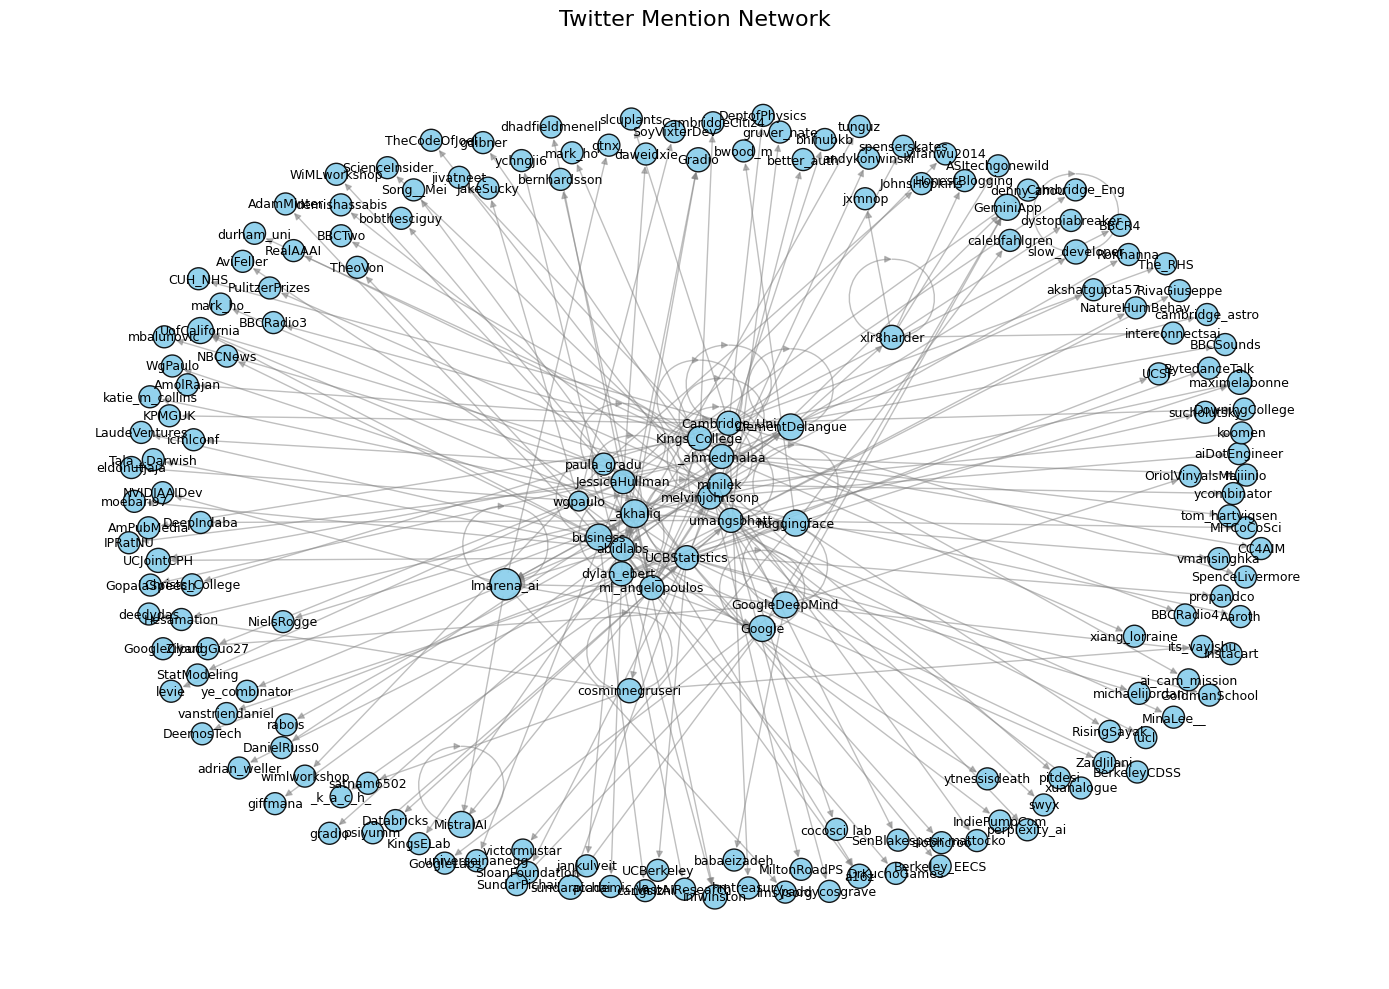

In [ ]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import os

# ---------- CONFIGURATION ----------
json_file = "mention_networks/WgPaulo_2_10.json"

# ---------- LOAD JSON ----------
if not os.path.exists(json_file):
    raise FileNotFoundError(f"❌ JSON file not found: {json_file}")

with open(json_file, "r", encoding="utf-8") as f:
    edges = json.load(f)

# ---------- BUILD GRAPH ----------
G = nx.DiGraph()
G.add_edges_from(edges)

# Node size based on in-degree (times mentioned)
mention_counts = dict(G.in_degree())
node_sizes = [200 + 50 * mention_counts.get(node, 0) for node in G.nodes()]

# ---------- DRAW GRAPH ----------
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue", alpha=0.9, edgecolors="black")
nx.draw_networkx_edges(G, pos, edge_color="gray", arrows=True, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")

plt.title("Twitter Mention Network", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()


# Depth Hihglighted

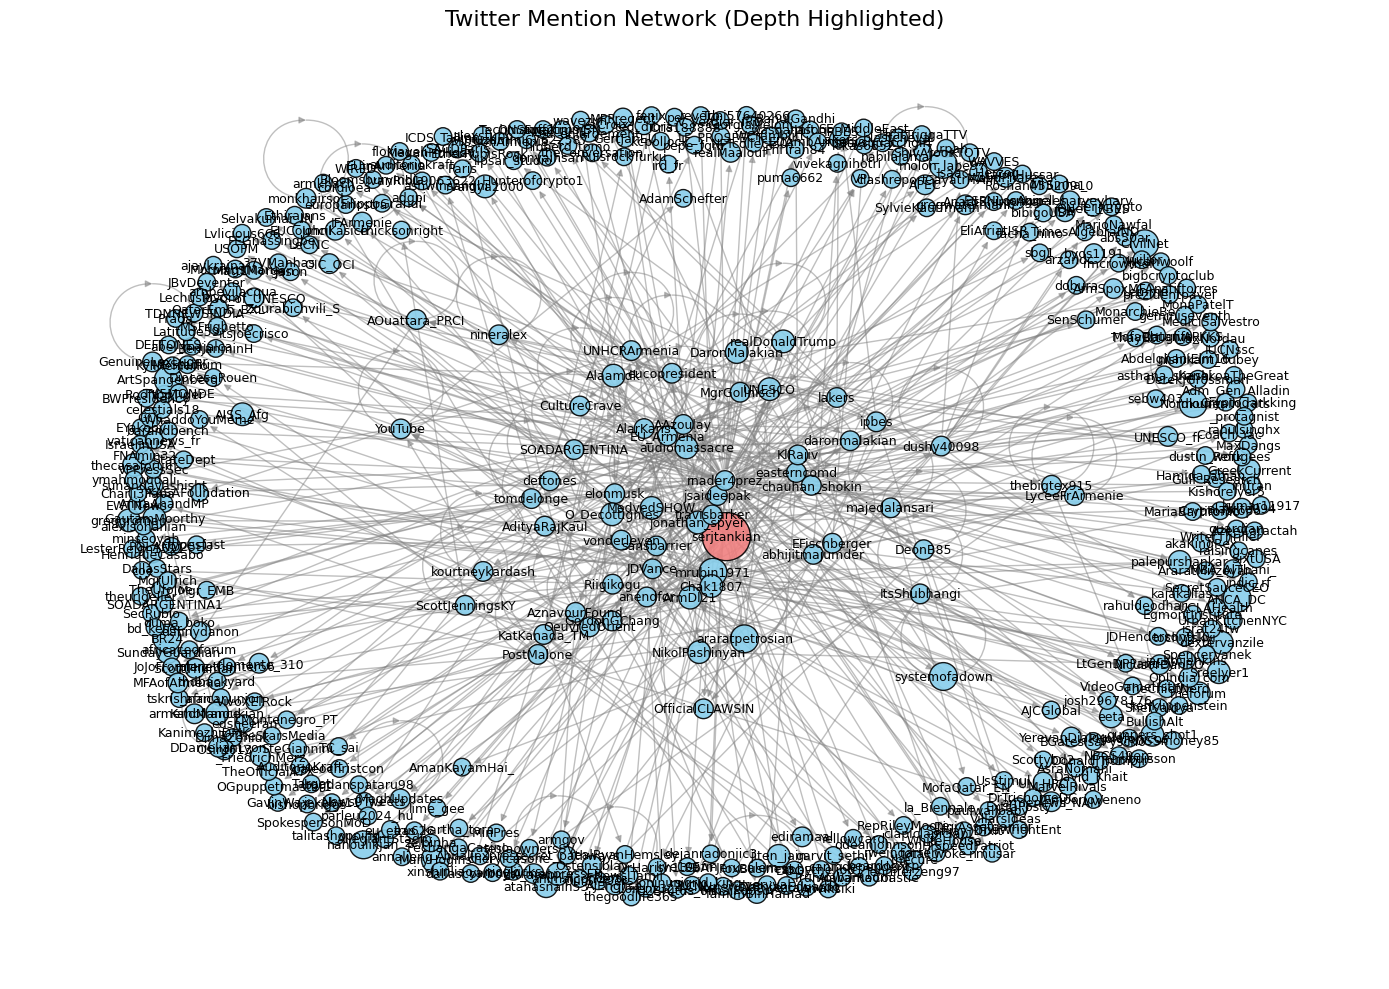

In [8]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import os

# ---------- CONFIGURATION ----------
json_file = "mention_networks/serjtankian_3_10.json"
start_user = "serjtankian"  # Starting node to highlight

# ---------- LOAD JSON ----------
if not os.path.exists(json_file):
    raise FileNotFoundError(f"❌ JSON file not found: {json_file}")

with open(json_file, "r", encoding="utf-8") as f:
    edges = json.load(f)

# ---------- BUILD GRAPH ----------
G = nx.DiGraph()
G.add_edges_from(edges)

# Compute shortest path length from start_user
depths = dict(nx.single_source_shortest_path_length(G, start_user))

# Node size based on depth (closer = bigger)
max_depth = max(depths.values()) if depths else 1
node_sizes = []
node_colors = []
for node in G.nodes():
    if node == start_user:
        node_sizes.append(1200)
        node_colors.append("lightcoral")  # Highlight starting node
    else:
        depth = depths.get(node, max_depth + 1)
        size = 800 / (depth + 1)
        node_sizes.append(size)
        node_colors.append("skyblue")

# ---------- DRAW GRAPH ----------
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9, edgecolors="black")
nx.draw_networkx_edges(G, pos, edge_color="gray", arrows=True, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")

plt.title("Twitter Mention Network (Depth Highlighted)", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

# Analize

In [5]:
import json

with open('mention_networks/serjtankian_3_10.json', 'r', encoding='utf-8') as f:
    edges = json.load(f)

unique_nodes = set()    # Sets only store unique values
for source, target in edges:
    unique_nodes.add(source)
    unique_nodes.add(target)

print(f"Number of unique nodes: {len(unique_nodes)}")

Number of unique nodes: 446


# Interactive Graph

In [6]:
import json
import networkx as nx
import plotly.graph_objects as go

# Load your edges from JSON or define them here
with open("mention_networks/serjtankian_3_10.json", "r", encoding="utf-8") as f:
    edges = json.load(f)

# Build directed graph
G = nx.DiGraph()
G.add_edges_from(edges)

start_user = "serjtankian"

# Compute shortest path length from start_user
depths = dict(nx.single_source_shortest_path_length(G, start_user))

# Compute positions
pos = nx.spring_layout(G, k=0.5, seed=42)

# Extract node positions
x_nodes = [pos[node][0] for node in G.nodes()]
y_nodes = [pos[node][1] for node in G.nodes()]

# Edge traces
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Node trace
node_trace = go.Scatter(
    x=x_nodes, y=y_nodes,
    mode='markers+text',
    text=[str(node) for node in G.nodes()],
    textposition="top center",
    hoverinfo='text',
    marker=dict(
        showscale=False,
        color=["lightcoral" if node == start_user else "skyblue" for node in G.nodes()],
        size=[200 if node == start_user else 100/(depths.get(node, max(depths.values())+1)+1) for node in G.nodes()],
        line_width=2))

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Interactive Twitter Mention Network",
                    title_font_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()
